In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import re
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score

### Import & Housekeeping

In [3]:
movie_df = pd.read_csv('../04_Data/1988_1997_merged_featurized.csv', index_col=0)

In [4]:
#Set groups of column names to make subsequent plots modular
target = ["usa_box"]
info = ["prod_budget", 'series', "runtime"] 
theater = ["title", "theaters"]
mpaa = ["PG", "R", "PG-13", "G"]
genre = ["action", "comedy", "drama", "horror", "scifi/fantasy", "romance", "animation", "other"]

columns = info + mpaa + genre + theater + target  #this is all the columns

In [5]:
#isolate the columns with features and target
movie_df = movie_df[columns]

In [6]:
#clean & isolate

#this removes from the set any movie less than 600 Theater Locations (aka Limited Release)
movie_df = movie_df[movie_df["theaters"]>=600] 

#this removes from the set any movie with no production budget
movie_df = movie_df.dropna(how='any').reset_index()

In [7]:
movie_df.count()

index            433
prod_budget      433
series           433
runtime          433
PG               433
R                433
PG-13            433
G                433
action           433
comedy           433
drama            433
horror           433
scifi/fantasy    433
romance          433
animation        433
other            433
title            433
theaters         433
usa_box          433
dtype: int64

In [8]:
movie_df.shape   #433 Movies that contain a budget on The-Numbers.com

(433, 19)

In [9]:
movie_df.info()   #no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 19 columns):
index            433 non-null int64
prod_budget      433 non-null float64
series           433 non-null float64
runtime          433 non-null float64
PG               433 non-null int64
R                433 non-null int64
PG-13            433 non-null int64
G                433 non-null int64
action           433 non-null int64
comedy           433 non-null int64
drama            433 non-null int64
horror           433 non-null int64
scifi/fantasy    433 non-null int64
romance          433 non-null int64
animation        433 non-null int64
other            433 non-null int64
title            433 non-null object
theaters         433 non-null float64
usa_box          433 non-null float64
dtypes: float64(5), int64(13), object(1)
memory usage: 64.4+ KB


### Set Columns For Study

In [10]:
X_columns = info + mpaa + genre

In [11]:
y = movie_df["usa_box"]
X = movie_df.loc[:,X_columns]

### Partition data + Make KFolds

In [12]:
#hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=30) #keep at 20 to be consistent

#hold out 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3) 

In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

#this helps with the way kf will generate indices below
# X, y = np.array(X), np.array(y)

### Scale Data - Hold for Regularization Later

In [14]:
#Feature scaling for train, val
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)           #Scale set for Regularization
X_test_scaled = scaler.transform(X_test)

X = scaler.fit_transform(X)                  #scale set for everything
X_test = scaler.transform(X_test)

### Model 1A:  Cross Validation - Linear Regression

In [15]:
lmcv = LinearRegression()

linear_model = cross_val_score(lmcv, X, y,    # estimator, features, target
                                cv=kf,        # number of folds 
                                scoring='r2') # scoring metric

In [16]:
print(linear_model)
print(linear_model.mean())

[0.33305362 0.14687686 0.31886472 0.20239258 0.32206673]
0.264650900259176


In [17]:
lmcv.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
lmcv.score(X_test,y_test)

0.33677174075181415

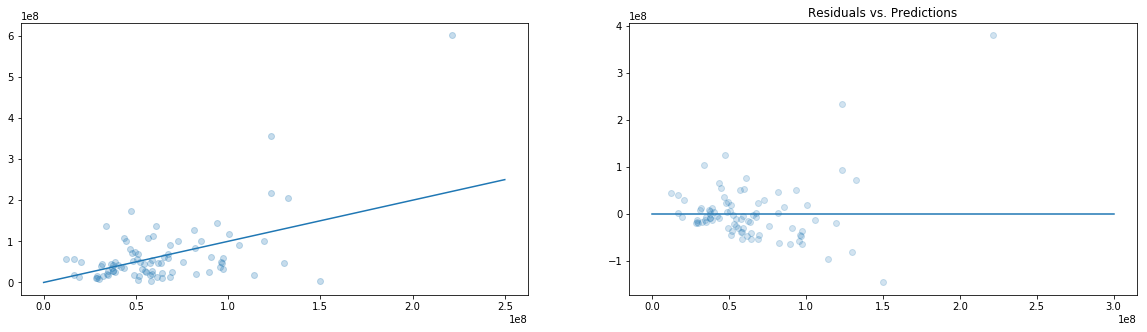

In [20]:
plt.figure(figsize=(20,5))

# Fitted vs. Actual
y_pred = lmcv.predict(X_test)

plt.subplot(1, 2, 1)
plt.scatter(y_pred,y_test, alpha=0.25)
plt.plot([0, 250000000], [0, 250000000])

# Residuals
lin_reg_residuals = y_test - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, lin_reg_residuals, alpha=.2)
plt.plot([0,300000000], [0, 0])
plt.title("Residuals vs. Predictions")
plt.savefig("residuals.pdf");

In [184]:
# These are the coefficients when it refit using that best alpha
list(zip(X_columns,lmcv.coef_))

[('prod_budget', 13945860.92266995),
 ('series', 15335071.670618972),
 ('runtime', 16681856.863900986),
 ('PG', 11287315.848072464),
 ('R', 2964512.0560520273),
 ('PG-13', 12349647.31483641),
 ('G', 3778609.723701964),
 ('action', -1719910.031726494),
 ('comedy', 6349335.028884313),
 ('drama', -1122436.5827562052),
 ('horror', -2200990.59772129),
 ('scifi/fantasy', 816351.3992960404),
 ('romance', 1736925.6116107698),
 ('animation', 13460608.920599012),
 ('other', -3475240.8546836236)]

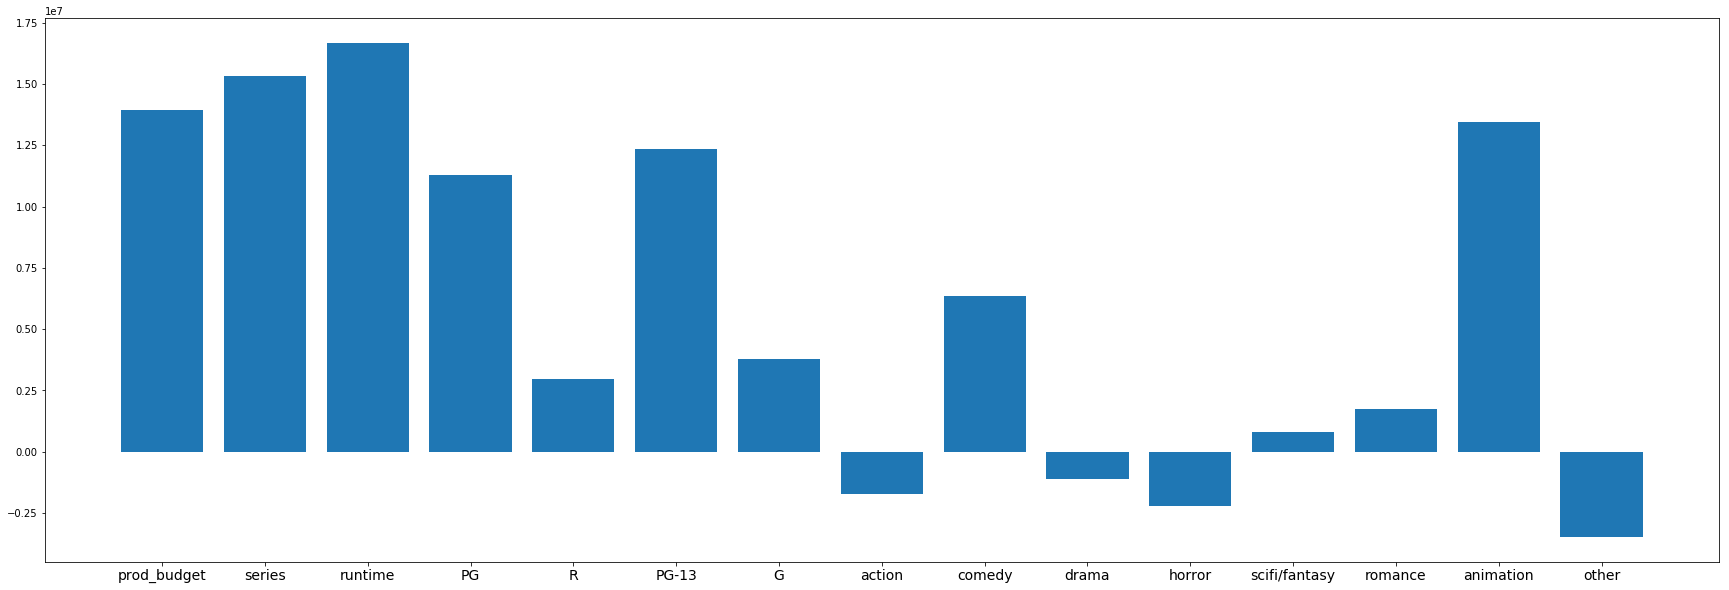

In [198]:
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize=14)
plt.bar(X_columns,lmcv.coef_)
plt.savefig("residuals.pdf");

### Model 2A: Cross Validation - Ridge Regression

In [186]:
lm_reg_cv = Ridge(alpha=1)

ridge_model =  cross_val_score(lm_reg_cv, X, y,    # estimator, features, target
                                cv=kf,             # number of folds 
                                scoring='r2')      # scoring metric

In [187]:
print(ridge_model)
print(ridge_model.mean())

[0.3338443  0.14899287 0.31882976 0.20318167 0.32203381]
0.26537648423800386


### Model 3A: Polynomial CV

In [188]:
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_poly = poly.fit_transform(X)
#X_test_poly = poly.transform(X_test)

lm_poly = LinearRegression()

poly_model =  cross_val_score(lm_poly, X_poly, y,    # estimator, features, target
                                cv=kf,                # number of folds 
                                scoring='r2')         # scoring metric

In [189]:
print(poly_model)
print(poly_model.mean())

[-6.03290067e+19 -2.91246341e+20 -3.41633845e+21 -1.23817833e+22
 -3.71256970e+21]
-3.9724533663411386e+21


### Model 4A: Cross Validation - Lasso

In [190]:
lasso_model = Lasso(alpha = 203091)  #this is a HIGH regularization strength!

lasso_model_cv = cross_val_score(lasso_model, X, y,    # estimator, features, target
                                cv=kf,        # number of folds 
                                scoring='r2') # scoring metric

In [191]:
print(lasso_model_cv)
print(lasso_model_cv.mean())

[0.33628179 0.15532572 0.31938197 0.20651352 0.32310224]
0.2681210463262338


In [192]:
lasso_model.fit(X,y)

Lasso(alpha=203091, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

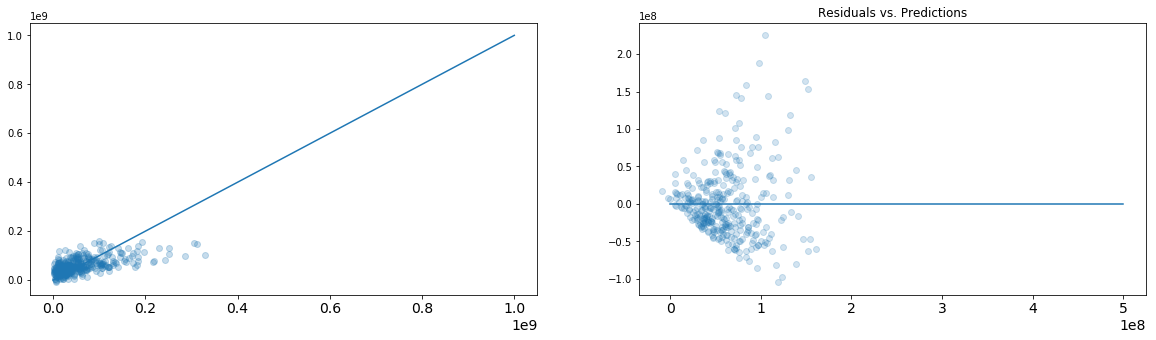

In [193]:
plt.figure(figsize=(20,5))

# Fitted vs. Actual
y_pred = lasso_model.predict(X)

plt.subplot(1, 2, 1)
plt.scatter(y, y_pred, alpha=0.25)
plt.plot([0, 1000000000], [0, 1000000000])

# Residuals
lin_reg_residuals = y - y_pred

plt.subplot(1, 2, 2)
plt.scatter(y_pred, lin_reg_residuals, alpha=.2)
plt.plot([0,500000000], [0, 0])
plt.title("Residuals vs. Predictions");

In [194]:
# These are the coefficients when it refit using that best alpha
list(zip(X_columns,lasso_model.coef_))

[('prod_budget', 13733206.298645632),
 ('series', 15089423.908056168),
 ('runtime', 16451190.70929989),
 ('PG', 1689421.8223785865),
 ('R', -9320269.381724995),
 ('PG-13', 1249417.5057293572),
 ('G', 0.0),
 ('action', -1043504.991775581),
 ('comedy', 6494089.627771135),
 ('drama', -793939.8958432823),
 ('horror', -1762545.7012209056),
 ('scifi/fantasy', 762935.203610733),
 ('romance', 1742747.8789618197),
 ('animation', 13127628.701075813),
 ('other', -3050184.912400073)]

### Model 5: Lasso CV

In [195]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,9,27)

lr_model_4A = LassoCV(alphas = alphavec, cv=5)
lr_model_4A.fit(X_scaled,y)

LassoCV(alphas=array([1.00000e-03, 2.89427e-03, 8.37678e-03, 2.42446e-02, 7.01704e-02,
       2.03092e-01, 5.87802e-01, 1.70125e+00, 4.92388e+00, 1.42510e+01,
       4.12463e+01, 1.19378e+02, 3.45511e+02, 1.00000e+03, 2.89427e+03,
       8.37678e+03, 2.42446e+04, 7.01704e+04, 2.03092e+05, 5.87802e+05,
       1.70125e+06, 4.92388e+06, 1.42510e+07, 4.12463e+07, 1.19378e+08,
       3.45511e+08, 1.00000e+09]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [196]:
# This is the best alpha value it found
lr_model_4A.alpha_

1701254.2798525926